In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import funnel as fnl

In [3]:
import socket
hostname = socket.getfqdn()
hostname

'casper09'

In [4]:
import ncar_jobqueue
#import dask_jobqueue
from dask.distributed import Client

try:
    cluster
    client
except: 
    cluster = ncar_jobqueue.NCARCluster(project='NCGD0011')
    #cluster = dask_jobqueue.PBSCluster(project='NCGD0011')
    cluster.adapt(minimum_jobs=0, maximum_jobs=24)
    client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.18:40296 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## set up parameters of analysis

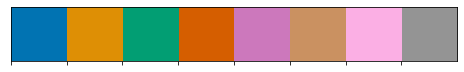

In [5]:
experiments = [
    'historical', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5', 'piControl',
]

variables = [
    'photoC_TOT_zint_100m',
    'photoC_diat_zint_100m',
    'photoC_TOT_zint',
    'photoC_diat_zint',
    'POC_FLUX_100m',
    'CaCO3_FLUX_100m',
    'diaz_Nfix',
    'NOx_FLUX',
    'NHy_FLUX',
    'FG_CO2',    
]

time_slices = {
    'historical': slice("1990-01-01", "2014-12-31"),
    'SSP1-2.6': slice("2090-01-01", "2099-12-31"),
    'SSP2-4.5': slice("2090-01-01", "2099-12-31"),
    'SSP3-7.0': slice("2090-01-01", "2099-12-31"),
    'SSP5-8.5': slice("2090-01-01", "2099-12-31"),
}

variable_labels = dict(
    FG_CO2='Air-sea CO$_2$ flux',
    photoC_TOT_zint_100m='NPP (z > -100m)',
    photoC_TOT_zint='NPP',
    POC_FLUX_100m='POC flux (100 m)',
)

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'piControl': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}


## get component objects

In [6]:
%%time
cmp = {}
for v in variables:
    cmp[v] = {}
    for e in experiments:
        cmp[v][e] = fnl.Component(
            model='cesm2',
            experiment=e,
            variable=v,
        )
cmp[v][e]

CPU times: user 1min 39s, sys: 3.77 s, total: 1min 43s
Wall time: 1min 42s


cesm2-piControl-ocn-pop.h-FG_CO2:
  catalog: /glade/u/home/mclong/p/cesm2-marbl/notebooks/funnel/catalogs/campaign-cesm2-cmip6-timeseries.json
  query: {'experiment': 'piControl', 'component': 'ocn', 'stream': 'pop.h', 'variable': ['FG_CO2']}
  assets: <campaign-cesm2-cmip6-timeseries catalog with 1 dataset(s) from 20 asset(s)>

## get datasets

In [7]:
%%time

dsets_ts = {}
dsets_map = {}
for v in variables:
    dsets_ts[v] = {}
    dsets_map[v] = {}
    for e in experiments:
        
        dsets_ts[v][e] = cmp[v][e].timeseries_ann(normalize=False,
                                                  persist=True,
                                                  clobber=False).compute()
        
        if e in time_slices:
            dsets_map[v][e] = cmp[v][e].time_mean(time_slice=time_slices[e],
                                                  persist=True,
                                                  clobber=False).compute()                

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-historical-ocn-pop.h-photoC_TOT_zint_100m/cesm2-historical-ocn-pop.h-photoC_TOT_zint_100m-timeseries-ann-dc1ef533967affdac7ff1871110271b5.zarr
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-historical-ocn-pop.h-photoC_TOT_zint_100m/cesm2-historical-ocn-pop.h-photoC_TOT_zint_100m-time-mean-6fad6ce941a1c7d777b07ba4db4b0728.zarr
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-SSP1-2.6-ocn-pop.h-photoC_TOT_zint_100m/cesm2-SSP1-2.6-ocn-pop.h-photoC_TOT_zint_100m-timeseries-ann-dc1ef533967affdac7ff1871110271b5.zarr
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/funnel/cesm2-SSP1-2.6-ocn-pop.h-photoC_TOT_zint_100m/cesm2-SSP1-2.6-ocn-pop.h-photoC_TOT_zint_100m-time-mean-753afc24686e480ead107b0e27f521b4.zarr
assuming cache is correct
reading cached file: /glade/

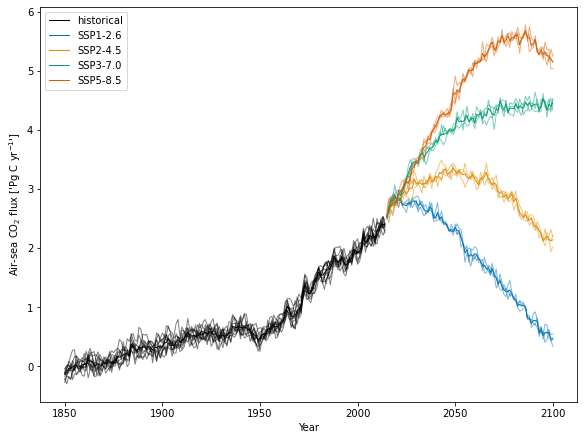

In [8]:
v = 'FG_CO2'

nrow = 1
ncol = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol*2, 3*nrow*2),
                       constrained_layout=True)

for e in experiments:
    if e == 'piControl': continue
    ds = dsets_ts[v][e]
    for member_id in ds.member_id.values:
        ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.5, linewidth=1, color=exp_colors[e])
    ax.plot(ds.time, ds[v].mean('member_id'), '-', linewidth=1, color=exp_colors[e], label=e)

ax.set_ylabel(f'{variable_labels[v]} {[ds[v].units]}')    
ax.set_xlabel('Year')
plt.legend();

sketching a "Collection" object below....

In [17]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json', sep=':')
variables = catalog.search(component='ocn').df.variable.unique()
variables = sorted(variables)

with open('all-ocn-vars.yml', 'w') as fid:
    for v in variables:
        fid.write(f'        - {v}\n')

In [18]:
from itertools import product
import pandas as pd

class Collection(object):
    """class to aggregate multiple `Components`"""
    
    def __init__(self, **indexes):
        keys = indexes.keys()

        index = pd.MultiIndex.from_product(
            [indexes[k] for k in keys], 
            names=keys,
        )
        
        components = [fnl.Component(**{k: v for k, v in zip(keys, vals)})
                      for vals in product(*[indexes[k] for k in keys])]
        self._data = pd.DataFrame(components, index=index)
    
        
x = Collection(
    model=['cesm2'],
    experiment=experiments,
    variable=variables,
)   
print(x._data)

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/intake_esm/core.py:675: UserWarning: Query returned zero results.
  warn(message)


                                                                                         0
model experiment variable                                                                 
cesm2 historical ABIO_ALK_SURF           cesm2-historical-ocn-pop.h-ABIO_ALK_SURF:\n  c...
                 ABIO_CO2STAR            cesm2-historical-ocn-pop.h-ABIO_CO2STAR:\n  ca...
                 ABIO_D14Catm            cesm2-historical-ocn-pop.h-ABIO_D14Catm:\n  ca...
                 ABIO_D14Cocn            cesm2-historical-ocn-pop.h-ABIO_D14Cocn:\n  ca...
                 ABIO_DCO2STAR           cesm2-historical-ocn-pop.h-ABIO_DCO2STAR:\n  c...
...                                                                                    ...
      piControl  zoo_loss_poc_zint_100m  cesm2-piControl-ocn-pop.h-zoo_loss_poc_zint_10...
                 zoo_loss_zint           cesm2-piControl-ocn-pop.h-zoo_loss_zint:\n  ca...
                 zoo_loss_zint_100m      cesm2-piControl-ocn-pop.h-zoo_loss_zint_100m:\...